In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
# setting display format so that large values are shown properly
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

sns.set_style(style='dark')
sns.set_context("notebook")

In [2]:
telecom_data = pd.read_csv('telecom_churn_data.csv')

In [3]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Columns: 226 entries, mobile_number to sep_vbc_3g
dtypes: float64(179), int64(35), object(12)
memory usage: 172.4+ MB


In [4]:
def get_columns_with_nan_percentage(df):
    nan_cols = [{
        "column":
        c,
        "percentage":
        round(100 * (df[c].isnull().sum() / len(df[c].index)), 2),
        "type":
        df[c].dtype
    } for c in df.columns
                if round(100 *
                         (df[c].isnull().sum() / len(df[c].index)), 2) > 0]
    return pd.DataFrame.from_records(nan_cols).sort_values(by=['percentage'],
                                                           ascending=False)


def convert_to_category(columns):
    for column in columns:
        telecom_data[column] = telecom_data[column].astype('object')


def get_int_float_columns_with_Zero_percentage(df):
    nan_cols = [{
        "column":
        c,
        "percentage":
        round(100 * ((df[c] == 0).sum() / len(df[c].index)), 2),
        "type":
        df[c].dtype
    } for c in df.columns
                if round(100 *
                         ((df[c] == 0).sum().sum() / len(df[c].index)), 2) > 0]
    return pd.DataFrame.from_records(nan_cols)


def get_columns_with_similar_values(df, threshold):
    columns_to_delete = []
    for c in df.columns:
        if (any(y > threshold for y in df[c].value_counts(
                dropna=False, normalize=True).tolist())):
            columns_to_delete.append(c)
    return columns_to_delete

## High value customers

In [5]:
## Columns: total_rech_data_6, av_rech_amt_data_6, total_rech_data_7 , av_rech_amt_data_7, total_rech_amt_6 and total_rech_amt_7 will be used to calcuate the high value customers.

# Filling NA values with 0

telecom_data[[
    'total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_data_7',
    'av_rech_amt_data_7', 'total_rech_amt_6', 'total_rech_amt_7'
]] = telecom_data[[
    'total_rech_data_6', 'av_rech_amt_data_6', 'total_rech_data_7',
    'av_rech_amt_data_7', 'total_rech_amt_6', 'total_rech_amt_7'
]].fillna(0)


def get_average_recharge(row):
    amount = 0.0
    amount += row['total_rech_data_6'] * row['av_rech_amt_data_6']
    amount += row['total_rech_data_7'] * row['av_rech_amt_data_7']
    amount += row['total_rech_amt_6']
    amount += row['total_rech_amt_7']

    return amount / 2.0


telecom_data['average_recharge_amount'] = telecom_data.apply(
    get_average_recharge, axis=1)

In [6]:
percentile_70 = telecom_data['average_recharge_amount'].quantile(.7)
percentile_70

478.0

In [7]:
# As per the problem statement, we need to consider customers as high value if they have more than 70 percentile expense
def check_high_value_customer(row):
    return 1 if row['average_recharge_amount'] > percentile_70 else 0


telecom_data['high_value_customer'] = telecom_data.apply(
    check_high_value_customer, axis=1)

In [8]:
telecom_data['high_value_customer'].value_counts()

0    70046
1    29953
Name: high_value_customer, dtype: int64

We can see that there are **29953** high value customer. From now onwards, we will only consider these customers for further analysis.

In [9]:
# Getting all the high value customers
telecom_data = telecom_data[telecom_data['high_value_customer'] == 1]

In [10]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29953 entries, 0 to 99997
Columns: 228 entries, mobile_number to high_value_customer
dtypes: float64(180), int64(36), object(12)
memory usage: 52.3+ MB


## Churned customers

In [11]:
def check_churn(row):
     return 1 if (row['total_ic_mou_9'] == 0 and row['total_og_mou_9'] == 0 and row['vol_2g_mb_9'] == 0 and row['vol_3g_mb_9'] == 0)  else 0

telecom_data['churn'] = telecom_data.apply(check_churn, axis=1)
telecom_data['churn'] = telecom_data['churn'].astype('category')

In [12]:
telecom_data['churn'].value_counts()

0    27520
1     2433
Name: churn, dtype: int64

Now we will delete columns for **September**

In [13]:
columns_to_drop = [c for c in telecom_data.columns if c.endswith("_9")]
telecom_data = telecom_data.drop(columns_to_drop, axis=1)

In [14]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

,column,percentage,type
120,fb_user_8,46.8000,float64
114,arpu_2g_8,46.8000,float64
101,max_rech_data_8,46.8000,float64
107,count_rech_3g_8,46.8000,float64
108,av_rech_amt_data_8,46.8000,float64
98,total_rech_data_8,46.8000,float64
97,date_of_last_rech_data_8,46.8000,object
104,count_rech_2g_8,46.8000,float64
111,arpu_3g_8,46.8000,float64
117,night_pck_user_8,46.8000,float64


We can see that there are many columns which are float and have NAN. We can fill them with 0

In [15]:
nan_df_numerical = nan_df[nan_df['type'] == 'float64']['column']
nan_df_numerical

120             fb_user_8
114             arpu_2g_8
101       max_rech_data_8
107       count_rech_3g_8
108    av_rech_amt_data_8
98      total_rech_data_8
104       count_rech_2g_8
111             arpu_3g_8
117      night_pck_user_8
115      night_pck_user_6
105       count_rech_3g_6
102       count_rech_2g_6
118             fb_user_6
112             arpu_2g_6
99        max_rech_data_6
109             arpu_3g_6
116      night_pck_user_7
106       count_rech_3g_7
119             fb_user_7
100       max_rech_data_7
110             arpu_3g_7
103       count_rech_2g_7
113             arpu_2g_7
52           spl_og_mou_8
46           std_og_mou_8
76       std_ic_t2f_mou_8
82           std_ic_mou_8
49           isd_og_mou_8
91            ic_others_8
73       std_ic_t2m_mou_8
64       loc_ic_t2f_mou_8
79       std_ic_t2o_mou_8
70       std_ic_t2t_mou_8
55            og_others_8
67           loc_ic_mou_8
58       loc_ic_t2t_mou_8
88           isd_ic_mou_8
85           spl_ic_mou_8
61       loc

In [16]:
telecom_data[nan_df_numerical] = telecom_data[nan_df_numerical].fillna(0)

In [17]:
nan_df = get_columns_with_nan_percentage(telecom_data)
nan_df

,column,percentage,type
7,date_of_last_rech_data_8,46.8000,object
5,date_of_last_rech_data_6,44.1100,object
6,date_of_last_rech_data_7,43.1200,object
4,date_of_last_rech_8,1.9400,object
1,last_date_of_month_8,0.5500,object
3,date_of_last_rech_7,0.3300,object
2,date_of_last_rech_6,0.2400,object
0,last_date_of_month_7,0.0900,object


In [18]:
columns_with_more_than_70_percent_same_value = get_columns_with_similar_values(telecom_data,.70)
columns_with_more_than_70_percent_same_value

['circle_id',
 'loc_og_t2o_mou',
 'std_og_t2o_mou',
 'loc_ic_t2o_mou',
 'last_date_of_month_6',
 'last_date_of_month_7',
 'last_date_of_month_8',
 'roam_ic_mou_6',
 'roam_ic_mou_7',
 'roam_ic_mou_8',
 'roam_og_mou_6',
 'roam_og_mou_7',
 'roam_og_mou_8',
 'loc_og_t2c_mou_6',
 'loc_og_t2c_mou_7',
 'loc_og_t2c_mou_8',
 'std_og_t2f_mou_6',
 'std_og_t2f_mou_7',
 'std_og_t2f_mou_8',
 'std_og_t2c_mou_6',
 'std_og_t2c_mou_7',
 'std_og_t2c_mou_8',
 'isd_og_mou_6',
 'isd_og_mou_7',
 'isd_og_mou_8',
 'og_others_6',
 'og_others_7',
 'og_others_8',
 'std_ic_t2f_mou_6',
 'std_ic_t2f_mou_7',
 'std_ic_t2f_mou_8',
 'std_ic_t2o_mou_6',
 'std_ic_t2o_mou_7',
 'std_ic_t2o_mou_8',
 'spl_ic_mou_6',
 'spl_ic_mou_7',
 'spl_ic_mou_8',
 'isd_ic_mou_6',
 'isd_ic_mou_7',
 'isd_ic_mou_8',
 'ic_others_6',
 'ic_others_7',
 'ic_others_8',
 'count_rech_3g_6',
 'count_rech_3g_7',
 'count_rech_3g_8',
 'night_pck_user_6',
 'night_pck_user_7',
 'night_pck_user_8',
 'monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'sachet

In [19]:
columns_with_more_than_70_percent_same_value.remove('churn')

In [20]:
print(columns_with_more_than_70_percent_same_value)

['circle_id', 'loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'roam_ic_mou_6', 'roam_ic_mou_7', 'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8', 'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8', 'std_og_t2f_mou_6', 'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_t2c_mou_6', 'std_og_t2c_mou_7', 'std_og_t2c_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8', 'og_others_6', 'og_others_7', 'og_others_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7', 'std_ic_t2f_mou_8', 'std_ic_t2o_mou_6', 'std_ic_t2o_mou_7', 'std_ic_t2o_mou_8', 'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6', 'isd_ic_mou_7', 'isd_ic_mou_8', 'ic_others_6', 'ic_others_7', 'ic_others_8', 'count_rech_3g_6', 'count_rech_3g_7', 'count_rech_3g_8', 'night_pck_user_6', 'night_pck_user_7', 'night_pck_user_8', 'monthly_2g_6', 'monthly_2g_7', 'monthly_2g_8', 'sachet_2g_6', 'sachet_2g_8', 'monthly_3g_6', 'monthly_3g_7

In [21]:
telecom_data = telecom_data.drop(columns_with_more_than_70_percent_same_value,
                                 axis=1)

In [22]:
telecom_data.shape

(29953, 113)

## New derived features

In [23]:
# Creating new columns for the month wise amount spent
def month_wise_amount_spent(row, month):
    return row['total_rech_amt_' + month] + (row['total_rech_data_' + month] *
                                             row['av_rech_amt_data_' + month])

In [24]:
telecom_data['total_amount_spent_6'] = telecom_data.apply(
    month_wise_amount_spent, args=('6'), axis=1)
telecom_data['total_amount_spent_7'] = telecom_data.apply(
    month_wise_amount_spent, args=('7'), axis=1)
telecom_data['total_amount_spent_8'] = telecom_data.apply(
    month_wise_amount_spent, args=('8'), axis=1)

Now we can delete the columns which we used to calculate the total monthly amount.

In [25]:
telecom_data = telecom_data.drop([
    'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
    'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8',
    'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
    'total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8',
    'max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8', 'max_rech_data_6',
    'max_rech_data_7', 'max_rech_data_8'
],
                                 axis=1)

In [26]:
telecom_data.shape

(29953, 98)

## Analysis of the data
Reference for the following methods: https://towardsdatascience.com/a-starter-pack-to-exploratory-data-analysis-with-python-pandas-seaborn-and-scikit-learn-a77889485baf#89dd and the previous assignments.

In [27]:
default_figsize = (15, 5)
default_xtick_angle = 50

In [28]:
def categorical_summarized(dataframe,
                           x=None,
                           y=None,
                           hue=None,
                           palette='Set1',
                           verbose=True,
                           figsize=default_figsize,
                           title="",
                           xlabel=None,
                           ylabel=None,
                           rotate_labels=False):
    '''
    Helper function that gives a quick summary of a given column of categorical data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data, y would be the count
    y: str. vertical axis to plot the labels of categorical data, x would be the count
    hue: str. if you want to compare it another variable (usually the target variable)
    palette: array-like. Colour of the plot
    Returns
    =======
    Quick Stats of the data and also the count plot
    '''
    if x == None:
        column_interested = y
    else:
        column_interested = x
    series = dataframe[column_interested]

    if verbose:
        print(series.describe())
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())

    sns.set(rc={'figure.figsize': figsize})
    sorted_df = dataframe.sort_values(column_interested)
    ax = sns.countplot(x=x, y=y, hue=hue, data=sorted_df)

    plt.title(title)
    if not xlabel:
        xlabel = column_interested
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    total = len(dataframe[column_interested])
    if rotate_labels:
        plt.setp(ax.get_xticklabels(),
                 rotation=30,
                 horizontalalignment='right')
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height() / 2
        ax.annotate(percentage, (x, y))
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [29]:
def quantitative_summarized(dataframe,
                            x=None,
                            y=None,
                            hue=None,
                            palette='Set1',
                            ax=None,
                            verbose=True,
                            swarm=False,
                            figsize=default_figsize):
    '''
    Helper function that gives a quick summary of quantattive data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlayed
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    '''
    series = dataframe[y]
    print(series.describe())
    if verbose:
        print('mode: ', series.mode())
        print('=' * 80)
        print(series.value_counts())
    sns.set(rc={'figure.figsize': figsize})

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x,
                      y=y,
                      hue=hue,
                      data=dataframe,
                      palette=palette,
                      ax=ax)
    plt.tight_layout()
    plt.style.use('fivethirtyeight')
    plt.xticks(rotation=default_xtick_angle)
    plt.show()

In [30]:
def plot_column(df,
                col,
                chart_type='Hist',
                dtype=int,
                bins=25,
                figsize=default_figsize):
    temp_df = df[col]
    sns.set(rc={'figure.figsize': figsize})
    if chart_type == 'Hist':
        ax = sns.countplot(temp_df)
    elif chart_type == 'Dens':
        ax = sns.distplot(temp_df)
    xmin, xmax = ax.get_xlim()
    ax.set_xticks(np.round(np.linspace(xmin, xmax, bins), 2))
    plt.tight_layout()
    plt.locator_params(axis='y', nbins=6)
    plt.xticks(rotation=default_xtick_angle)
    plt.style.use('fivethirtyeight')
    plt.show()

In [31]:
def univariate_analysis(col,
                        chart_type='Dens',
                        df=telecom_data,
                        is_categorical=False,
                        title="",
                        xlabel=None,
                        ylabel=None,
                        rotate_labels=False,
                        bins=25):
    if is_categorical:
        categorical_summarized(df,
                               x=col,
                               title=title,
                               xlabel=xlabel,
                               ylabel=ylabel,
                               rotate_labels=rotate_labels,
                               verbose=False)
    else:
        quantitative_summarized(df, y=col, verbose=False)
        plot_column(df, col, chart_type=chart_type, bins=bins)

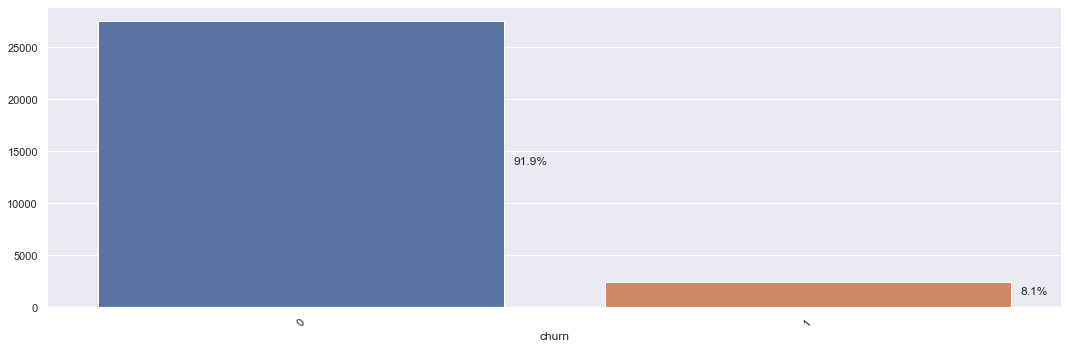

In [32]:
univariate_analysis('churn', is_categorical=True)